# NN BASICS

In [1]:
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Helpers

In [170]:
def calculateOutput(layer:torch.nn.modules.linear.Linear, input_arr:np.ndarray,
            is_relu=True)->np.ndarray:
    """
    Calculates the output from a liner layer.
       N - number of samples
       O - number of outputs
       I - number of inputs

    Args:
        layer: Linear layer
        input_arr: np.Array (N X I)

    Returs
        np.array: N X O
    """
    num_input = layer.in_features
    num_output = layer.out_features
    # Get the weights
    A_tensor = list(layer.named_parameters())[0][1]
    #
    b_tensor = torch.detach((list(layer.named_parameters())[1][1])).clone()
    #
    weight_product_tensor = A_tensor.detach().matmul(input_arr)  # rows are outputs, columns are samples
    result = weight_product_tensor + b_tensor.reshape(num_output, 1)
    if is_relu:
        result = nn.ReLU()(result)
    return result.detach().numpy().T
    
######### TESTS
# Setup
test_data_arr = np.array([ [1, 2],
                      [10, 20],
                      [100, 200],
                         ], dtype=float)
input_arr = torch.tensor(test_data_arr.T).to(torch.float32)
layer = nn.Linear(2, 4)
layer_tensor = layer(input_arr.T).detach()
#
result = calculateOutput(layer, input_arr, is_relu=False)
assert(np.sum((result - layer_tensor.numpy())**2) <= 1e-5)
# With relu
result = calculateOutput(layer, input_arr, is_relu=True)
assert(np.sum((result - nn.ReLU()(layer_tensor).numpy())**2) <= 1e-5)
print("OK!")

OK!


In [156]:
dir(layer)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__constants__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_per

# Get GPU

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


# Basic Network

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 3),
            nn.ReLU(),
            nn.Linear(3, 4),
            nn.ReLU(),
            nn.Linear(4, 5),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [4]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=5, bias=True)
  )
)


In [5]:
X = torch.rand(1, 2, 1, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([3], device='mps:0')


In [6]:
pred_probab

tensor([[0.1628, 0.1750, 0.2248, 0.2270, 0.2103]], device='mps:0',
       grad_fn=<SoftmaxBackward0>)

In [122]:
pred_probab.argmax(0)

tensor([0, 0, 0, 0, 0], device='mps:0')

In [7]:
named_parameters = list(model.named_parameters())
[(x[0], len(x[1])) for x in named_parameters]

[('linear_relu_stack.0.weight', 3),
 ('linear_relu_stack.0.bias', 3),
 ('linear_relu_stack.2.weight', 4),
 ('linear_relu_stack.2.bias', 4),
 ('linear_relu_stack.4.weight', 5),
 ('linear_relu_stack.4.bias', 5)]

# NN Operation

NN operation is a matrix multiplication. ReLU provides thresholding.
One challenge is managing the inputs to and outputs from a neuron.

# Autoencoders

In [175]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# 1. Basic Fully Connected Autoencoder
class BasicAutoencoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, latent_dim=64):
        super(BasicAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # For image data normalized to [0,1]
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)

# 2. Convolutional Autoencoder (better for images)
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 14x14 -> 7x7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)                       # 7x7 -> 1x1
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),                      # 1x1 -> 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1), # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # 14x14 -> 28x28
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 3. Variational Autoencoder (VAE)
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # mu
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # logvar
        
        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
    
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function for VAE
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# 4. Denoising Autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, latent_dim=64):
        super(DenoisingAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Training function
def train_autoencoder(model, dataloader, num_epochs=10, lr=1e-3, model_type='basic'):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)
            
            if model_type == 'basic' or model_type == 'denoising':
                data = data.view(data.size(0), -1)  # Flatten for FC layers
                
                if model_type == 'denoising':
                    # Add noise to input
                    noise = torch.randn_like(data) * 0.3
                    noisy_data = data + noise
                    noisy_data = torch.clamp(noisy_data, 0., 1.)
                    output = model(noisy_data)
                else:
                    output = model(data)
                
                loss = criterion(output, data)
                
            elif model_type == 'conv':
                output = model(data)
                loss = criterion(output, data)
                
            elif model_type == 'vae':
                recon_batch, mu, logvar = model(data)
                loss = vae_loss(recon_batch, data, mu, logvar)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
    return losses

# Visualization function
def visualize_results(model, dataloader, model_type='basic', num_images=8):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(dataloader))
        data = data[:num_images].to(device)
        
        if model_type == 'basic' or model_type == 'denoising':
            data_flat = data.view(data.size(0), -1)
            if model_type == 'denoising':
                # Add noise for demonstration
                noise = torch.randn_like(data_flat) * 0.3
                noisy_data = data_flat + noise
                noisy_data = torch.clamp(noisy_data, 0., 1.)
                reconstructed = model(noisy_data)
            else:
                reconstructed = model(data_flat)
            reconstructed = reconstructed.view(-1, 1, 28, 28)
            
        elif model_type == 'conv':
            reconstructed = model(data)
            
        elif model_type == 'vae':
            reconstructed, _, _ = model(data)
            reconstructed = reconstructed.view(-1, 1, 28, 28)
    
    # Plot original and reconstructed images
    fig, axes = plt.subplots(2, num_images, figsize=(12, 4))
    for i in range(num_images):
        # Original
        axes[0, i].imshow(data[i].cpu().squeeze(), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        
        # Reconstructed
        axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=transform
    )
    
    train_loader = DataLoader(
        train_dataset, batch_size=128, shuffle=True
    )
    
    # Example 1: Basic Autoencoder
    print("Training Basic Autoencoder...")
    basic_ae = BasicAutoencoder().to(device)
    basic_losses = train_autoencoder(basic_ae, train_loader, num_epochs=5, model_type='basic')
    
    # Example 2: Convolutional Autoencoder
    # FIXME: Problem with the NN definition or data that is dimensioned wrong.
    #print("\nTraining Convolutional Autoencoder...")
    #conv_ae = ConvAutoencoder().to(device)
    #conv_losses = train_autoencoder(conv_ae, train_loader, num_epochs=5, model_type='conv')
    conv_losses = [np.nan]
    
    # Example 3: Variational Autoencoder
    print("\nTraining Variational Autoencoder...")
    vae = VAE().to(device)
    vae_losses = train_autoencoder(vae, train_loader, num_epochs=5, model_type='vae')
    
    # Example 4: Denoising Autoencoder
    print("\nTraining Denoising Autoencoder...")
    denoising_ae = DenoisingAutoencoder().to(device)
    denoising_losses = train_autoencoder(denoising_ae, train_loader, num_epochs=5, model_type='denoising')
    
    # Visualize results (uncomment to see plots)
    # visualize_results(basic_ae, train_loader, 'basic')
    # visualize_results(conv_ae, train_loader, 'conv')
    # visualize_results(vae, train_loader, 'vae')
    # visualize_results(denoising_ae, train_loader, 'denoising')
    
    print("\nTraining completed!")
    print(f"Final losses - Basic: {basic_losses[-1]:.4f}, Conv: {conv_losses[-1]:.4f}, "
          f"VAE: {vae_losses[-1]:.4f}, Denoising: {denoising_losses[-1]:.4f}")

Using mps device
Training Basic Autoencoder...
Epoch [1/5], Loss: 0.0500
Epoch [2/5], Loss: 0.0220
Epoch [3/5], Loss: 0.0167
Epoch [4/5], Loss: 0.0136
Epoch [5/5], Loss: 0.0118

Training Variational Autoencoder...
Epoch [1/5], Loss: 21122.5012
Epoch [2/5], Loss: 15497.6482
Epoch [3/5], Loss: 14616.2168
Epoch [4/5], Loss: 14236.7660
Epoch [5/5], Loss: 14029.5964

Training Denoising Autoencoder...
Epoch [1/5], Loss: 0.0588
Epoch [2/5], Loss: 0.0344
Epoch [3/5], Loss: 0.0300
Epoch [4/5], Loss: 0.0281
Epoch [5/5], Loss: 0.0270

Training completed!
Final losses - Basic: 0.0118, Conv: nan, VAE: 14029.5964, Denoising: 0.0270


# Hooks

Model architecture:
LinearNetwork(
  (network): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=12, bias=True)
    (3): ReLU()
    (4): Linear(in_features=12, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=3, bias=True)
  )
)

FORWARD HOOKS EXAMPLE
=== Activation Analysis ===

Layer: network.0
  Shape: torch.Size([32, 16])
  Mean: 0.0639
  Std: 0.5931
  Min: -1.7846
  Max: 1.7289
  Dead neurons: 0/16

Layer: network.2
  Shape: torch.Size([32, 12])
  Mean: 0.0249
  Std: 0.2916
  Min: -0.6189
  Max: 0.9948
  Dead neurons: 0/12

Layer: network.4
  Shape: torch.Size([32, 8])
  Mean: 0.0649
  Std: 0.2124
  Min: -0.3979
  Max: 0.4775
  Dead neurons: 0/8

Layer: network.6
  Shape: torch.Size([32, 3])
  Mean: 0.2389
  Std: 0.1751
  Min: 0.0140
  Max: 0.5432
  Dead neurons: 0/3


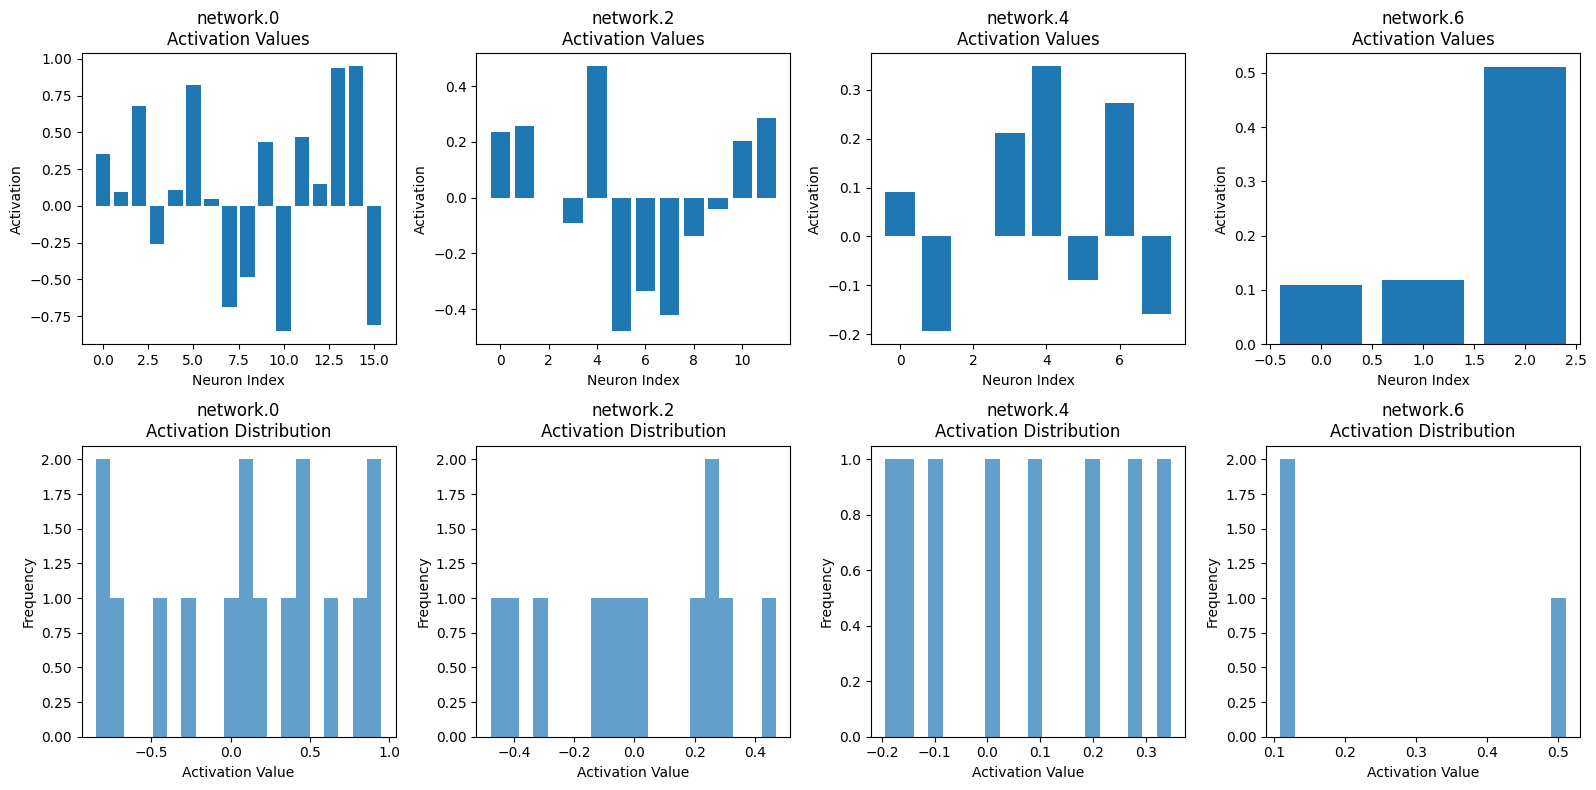


GRADIENT HOOKS EXAMPLE

=== Gradient Analysis ===

Layer: network.6
  Gradient shape: torch.Size([32, 3])
  Gradient norm: 0.145963
  Gradient mean: -0.000000

Layer: network.4
  Gradient shape: torch.Size([32, 8])
  Gradient norm: 0.091885
  Gradient mean: 0.000337

Layer: network.2
  Gradient shape: torch.Size([32, 12])
  Gradient norm: 0.033698
  Gradient mean: 0.000075

Layer: network.0
  Gradient shape: torch.Size([32, 16])
  Gradient norm: 0.013448
  Gradient mean: 0.000024

SPECIFIC LAYER MONITORING
=== Activation Analysis ===

Layer: network.0
  Shape: torch.Size([32, 16])
  Mean: 0.0639
  Std: 0.5931
  Min: -1.7846
  Max: 1.7289
  Dead neurons: 0/16

Layer: network.2
  Shape: torch.Size([32, 12])
  Mean: 0.0249
  Std: 0.2916
  Min: -0.6189
  Max: 0.9948
  Dead neurons: 0/12

=== Hook Usage Complete ===
Hooks allow you to:
1. Extract intermediate activations without modifying the model
2. Monitor gradients during backpropagation
3. Debug network behavior and identify issues
4.

In [177]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class LinearNetwork(nn.Module):
    def __init__(self, input_size=10, hidden_sizes=[20, 15, 10], output_size=5):
        super(LinearNetwork, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Create hidden layers
        for i, hidden_size in enumerate(hidden_sizes):
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, output_size))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

class ActivationExtractor:
    """Class to handle activation extraction using hooks"""
    
    def __init__(self, model):
        self.model = model
        self.activations = {}
        self.hooks = []
        self.layer_names = []
    
    def get_activation(self, name):
        """Create a hook function that saves activations"""
        def hook(module, input, output):
            # Store both input and output
            self.activations[name] = {
                'input': input[0].detach().clone() if isinstance(input, tuple) else input.detach().clone(),
                'output': output.detach().clone()
            }
        return hook
    
    def register_hooks(self, layers_to_monitor='all'):
        """Register forward hooks on specified layers"""
        
        if layers_to_monitor == 'all':
            # Monitor all Linear layers
            for name, module in self.model.named_modules():
                if isinstance(module, nn.Linear):
                    hook = module.register_forward_hook(self.get_activation(name))
                    self.hooks.append(hook)
                    self.layer_names.append(name)
        else:
            # Monitor specific layers
            for layer_name in layers_to_monitor:
                module = dict(self.model.named_modules())[layer_name]
                hook = module.register_forward_hook(self.get_activation(layer_name))
                self.hooks.append(hook)
                self.layer_names.append(layer_name)
    
    def remove_hooks(self):
        """Remove all registered hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
    
    def get_activations(self):
        """Return stored activations"""
        return self.activations
    
    def clear_activations(self):
        """Clear stored activations"""
        self.activations = {}

def analyze_activations(activations, layer_names):
    """Analyze and visualize activation statistics"""
    
    print("=== Activation Analysis ===")
    
    for layer_name in layer_names:
        if layer_name in activations:
            output = activations[layer_name]['output']
            
            print(f"\nLayer: {layer_name}")
            print(f"  Shape: {output.shape}")
            print(f"  Mean: {output.mean().item():.4f}")
            print(f"  Std: {output.std().item():.4f}")
            print(f"  Min: {output.min().item():.4f}")
            print(f"  Max: {output.max().item():.4f}")
            
            # Check for dead neurons (always zero output)
            if len(output.shape) > 1:
                dead_neurons = (output.abs().sum(dim=0) == 0).sum().item()
                total_neurons = output.shape[1]
                print(f"  Dead neurons: {dead_neurons}/{total_neurons}")

def visualize_activations(activations, layer_names, sample_idx=0):
    """Visualize activations for a specific sample"""
    
    fig, axes = plt.subplots(2, len(layer_names), figsize=(4*len(layer_names), 8))
    if len(layer_names) == 1:
        axes = axes.reshape(2, 1)
    
    for i, layer_name in enumerate(layer_names):
        if layer_name in activations:
            output = activations[layer_name]['output']
            
            # Plot activation values
            axes[0, i].bar(range(output.shape[1]), output[sample_idx].detach().numpy())
            axes[0, i].set_title(f'{layer_name}\nActivation Values')
            axes[0, i].set_xlabel('Neuron Index')
            axes[0, i].set_ylabel('Activation')
            
            # Plot activation histogram
            axes[1, i].hist(output[sample_idx].detach().numpy(), bins=20, alpha=0.7)
            axes[1, i].set_title(f'{layer_name}\nActivation Distribution')
            axes[1, i].set_xlabel('Activation Value')
            axes[1, i].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

def gradient_hook_example(model):
    """Example of using backward hooks to capture gradients"""
    
    gradients = {}
    
    def get_gradient_hook(name):
        def hook(module, grad_input, grad_output):
            gradients[name] = {
                'grad_input': grad_input[0].detach().clone() if grad_input[0] is not None else None,
                'grad_output': grad_output[0].detach().clone() if grad_output[0] is not None else None
            }
        return hook
    
    # Register backward hooks
    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            hook = module.register_full_backward_hook(get_gradient_hook(name))
            hooks.append(hook)
    
    return gradients, hooks

# Example usage
if __name__ == "__main__":
    # Create model and data
    model = LinearNetwork(input_size=8, hidden_sizes=[16, 12, 8], output_size=3)
    
    # Create sample data
    batch_size = 32
    input_data = torch.randn(batch_size, 8)
    target = torch.randint(0, 3, (batch_size,))
    
    print("Model architecture:")
    print(model)
    
    # === FORWARD HOOKS EXAMPLE ===
    print("\n" + "="*50)
    print("FORWARD HOOKS EXAMPLE")
    print("="*50)
    
    # Create activation extractor
    extractor = ActivationExtractor(model)
    
    # Register hooks for all Linear layers
    extractor.register_hooks(layers_to_monitor='all')
    
    # Forward pass
    model.eval()
    with torch.no_grad():
        output = model(input_data)
    
    # Get activations
    activations = extractor.get_activations()
    
    # Analyze activations
    analyze_activations(activations, extractor.layer_names)
    
    # Visualize activations
    visualize_activations(activations, extractor.layer_names, sample_idx=0)
    
    # Clean up
    extractor.remove_hooks()
    
    # === GRADIENT HOOKS EXAMPLE ===
    print("\n" + "="*50)
    print("GRADIENT HOOKS EXAMPLE")
    print("="*50)
    
    # Set up gradient hooks
    gradients, grad_hooks = gradient_hook_example(model)
    
    # Forward and backward pass
    model.train()
    criterion = nn.CrossEntropyLoss()
    
    output = model(input_data)
    loss = criterion(output, target)
    loss.backward()
    
    # Analyze gradients
    print("\n=== Gradient Analysis ===")
    for layer_name, grad_data in gradients.items():
        if grad_data['grad_output'] is not None:
            grad = grad_data['grad_output']
            print(f"\nLayer: {layer_name}")
            print(f"  Gradient shape: {grad.shape}")
            print(f"  Gradient norm: {grad.norm().item():.6f}")
            print(f"  Gradient mean: {grad.mean().item():.6f}")
    
    # Clean up gradient hooks
    for hook in grad_hooks:
        hook.remove()
    
    # === SPECIFIC LAYER MONITORING ===
    print("\n" + "="*50)
    print("SPECIFIC LAYER MONITORING")
    print("="*50)
    
    # Monitor only specific layers
    extractor2 = ActivationExtractor(model)
    specific_layers = ['network.0', 'network.2']  # First and second Linear layers
    extractor2.register_hooks(layers_to_monitor=specific_layers)
    
    # Forward pass
    with torch.no_grad():
        output = model(input_data)
    
    # Get and analyze specific activations
    specific_activations = extractor2.get_activations()
    analyze_activations(specific_activations, specific_layers)
    
    # Clean up
    extractor2.remove_hooks()
    
    print(f"\n=== Hook Usage Complete ===")
    print("Hooks allow you to:")
    print("1. Extract intermediate activations without modifying the model")
    print("2. Monitor gradients during backpropagation") 
    print("3. Debug network behavior and identify issues")
    print("4. Analyze feature representations at different layers")